In [1]:
import math
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import cv2
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy

## 11110COM 526000 Deep Learning HW2:Variational Autoencoder

## Don't change the below two functions (compute_PSNR, compute_SSIM)!!
def compute_PSNR(img1, img2): ## 請輸入範圍在0~1的圖片!!!
    # Compute Peak Signal to Noise Ratio (PSNR) function
    # img1 and img2 > [0, 1] 
    
    img1 = torch.as_tensor(img1, dtype=torch.float32)# In tensor format!!
    img2 = torch.as_tensor(img2, dtype=torch.float32)
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * torch.log10(1 / torch.sqrt(mse))

def compute_SSIM(img1, img2): ## 請輸入範圍在0~1的圖片!!!
    # Compute Structure Similarity (SSIM) function
    # img1 and img2 > [0, 1]
    C1 = (0.01 * 1) ** 2
    C2 = (0.03 * 1) ** 2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()



In [2]:
batch = 20
## Feel free to adjust the codes in the hw2_template.py !!!

## Read the data
x = torch.tensor(np.load('eye/data.npy').astype(np.float32))
y = torch.tensor(np.load('eye/label.npy').astype(np.float32))
dataset = TensorDataset(x, y)
loader = DataLoader(dataset=dataset, shuffle=True, batch_size=batch)
total_loader = DataLoader(dataset=dataset, shuffle=True)


In [3]:
# print(np.load('eye/data.npy').astype(np.float32).shape)
# plt.imshow(np.load('eye/data.npy').astype(np.float32)[0])

In [4]:
torch.cuda.set_device(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
epoch = 400
lr = 0.0005
loss_his = []

class vae(nn.Module):
    def __init__(self):
        super(vae, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3*50*50, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU()
        )
        self.mean = nn.Linear(512, 256)
        self.variance = nn.Linear(512, 256)
        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 4096),
            nn.ReLU(),
            nn.Linear(4096, 3*50*50),
            nn.Sigmoid()
        )

    def encode(self,x):
        x = self.encoder(x)
        m = self.mean(x)
        v = self.variance(x)
        return m,v
    def forward(self, x):
        m,v = self.encode(x)
        e = torch.randn_like(v)
        t = m+e*torch.exp(v)
        out = self.decoder(t)
        return m, v, t, out

model2 = vae().to(device)
print(model2)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=lr)

# train
for e in range(epoch):
    train_loss = 0.0
    for d in loader:
        img, _ = d
        input_img = img.view(-1, 50*50*3).to(device)
        m, v, t, output = model2(input_img)
        sigma = torch.exp(v)
        kl_loss = (sigma**2 + m**2 - torch.log(sigma) - 1/2).sum()
        loss = ((input_img-output)**2).sum()+kl_loss
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
        train_loss += loss
  # print avg training statistics
    train_loss = train_loss/len(loader)
    loss_his.append(train_loss.detach().cpu().item())
    if (e+1)%20 == 0:
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(e+1, train_loss))
        # print('kl_loss={} mse={}'.format(kl_loss, mse_loss))

# evaluate
total_PSNR = 0
total_SSIM = 0
for d in total_loader:
    img, _ = d
    input_img = img.view(-1, 50*50*3).to(device)
    _, _,_,  output = model2(input_img)
    output = output.view(-1, 50, 50, 3).detach().cpu()
    total_PSNR += compute_PSNR(img.numpy().reshape(50,50,3), output.numpy().reshape(50,50,3))
    total_SSIM += compute_SSIM(img.numpy().reshape(50,50,3), output.numpy().reshape(50,50,3))
print('average PSNR={}, SSIM={}'.format(total_PSNR/len(total_loader), total_SSIM/len(total_loader)))

vae(
  (encoder): Sequential(
    (0): Linear(in_features=7500, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
  )
  (mean): Linear(in_features=512, out_features=256, bias=True)
  (variance): Linear(in_features=512, out_features=256, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=4096, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4096, out_features=7500, bias=True)
    (7): Sigmoid()
  )
)
Epoch: 20 	Training Loss: 5046.529297
Epoch: 40 	Training Loss: 4775.174316
Epoch: 60 	Training Loss: 4470.612305
Epoch: 80 	Training Loss: 4362.948242
Epoch: 100 	Training Loss: 4233.677246
Epoch: 120 	Training Loss: 4095.579102
Epoch: 140 	Trai

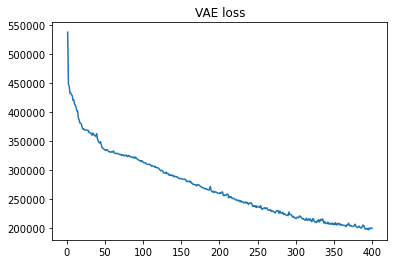

In [6]:
y_ = loss_his
x_ = np.array([i for i in range(1,401)])
plt.title('VAE loss')
plt.plot(x_, y_)

In [7]:
torch.save(model2,'VAE.pth')

In [8]:
decoder = model2.decoder
# Q4. use decoder
print(decoder)

Sequential(
  (0): Linear(in_features=256, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=1024, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1024, out_features=4096, bias=True)
  (5): ReLU()
  (6): Linear(in_features=4096, out_features=7500, bias=True)
  (7): Sigmoid()
)


In [ ]:
# evaluate
total_PSNR = 0
total_SSIM = 0
for d in total_loader:
    img, _ = d
    input_img = img.view(-1, 50*50*3).to(device)
    _, _,_,  output = model2(input_img)
    output = output.view(-1, 50, 50, 3).detach().cpu()
    print('output')
    arr_ = np.squeeze(output) # you can give axis attribute if you wanna squeeze in specific dimension
    plt.imshow(arr_)
    plt.show()
    total_PSNR += compute_PSNR(img.numpy().reshape(50,50,3), output.numpy().reshape(50,50,3))
    total_SSIM += compute_SSIM(img.numpy().reshape(50,50,3), output.numpy().reshape(50,50,3))
print('average PSNR={}, SSIM={}'.format(total_PSNR/len(total_loader), total_SSIM/len(total_loader)))


In [ ]:
i = 0
k = 0
reconstruct = np.zeros((100, 50, 50, 3))
for d in total_loader:
    if (i>=1 and i<=5) or (i>=226 and i<=230) or (i>=841 and i<=845) or (i>=1471 and i<=1475):
        img, _ = d
        input_img = img.view(-1, 50*50*3).to(device)
        for j in range(5):
            _, _, _, output = model2(input_img)
            output = output.view(-1, 50, 50, 3).detach().cpu()
            reconstruct[k] = output
            k += 1
    i += 1
np.save('gen_data.npy', reconstruct)

In [ ]:
import matplotlib.image
'''
3 -> 2
227 -> 6
841 -> 10
1475 -> 19
'''
out_id = [3, 6, 10, 19]
for i in out_id:
    for j in range(0,5):
        matplotlib.image.imsave('output_'+ str(i) + '-' + str(j+1) + '.png', np.squeeze(reconstruct[5*i+j]))

In [ ]:
#確保可以讀取
x = torch.tensor(np.load('gen_data.npy').astype(np.float32))
load = DataLoader(dataset=TensorDataset(x))
for d in load:
    img = d[0]
    print(img.shape)
    arr_ = np.squeeze(img) # you can give axis attribute if you wanna squeeze in specific dimension
#     plt.imshow(arr_)
#     plt.show()
    

In [ ]:
# load model
# m = vae().to(device)
# m.load_state_dict(torch.load('VAE.pth'))
# m.eval()